In [231]:
import numpy as np
import matplotlib.pyplot as plt

with open('binseq.txt', 'r') as f:
    binseq = f.readlines()
binseq = binseq[0].split(',')
binseq[-1] = '1'
binseq = [[float(y) for y in x] for x in binseq]
binseq = np.array(binseq)
binseq = binseq.squeeze()

In [232]:
from prox import prox_dp

import warnings
warnings.filterwarnings('ignore')

In [233]:
def g(theta,y):
    return np.sum(-y*theta+np.log(1+np.exp(theta)))

def h(theta,lam):
    return lam*np.sum(np.abs((theta - np.roll(theta,-1))[:-1]))

def gGrad(theta,y):
    return -y+(np.exp(theta)/(1+np.exp(theta)))

def obj(y,theta,lam):
    return g(y,theta)+h(theta,lam)

def Gt(theta,t,y,lam):
    theta_0 = theta.copy()
    prox_dp(n=theta.shape[0], y=theta_0-t*gGrad(theta_0,y), lam=lam*t, theta=theta)
    return (theta_0 - theta)/t

def gd(beta,y):
    return np.sum(np.log(1+np.exp(-y*beta)))
    
def hd(D,beta,lam):
    return lam*np.linalg.norm(np.dot(D,beta),1)
    


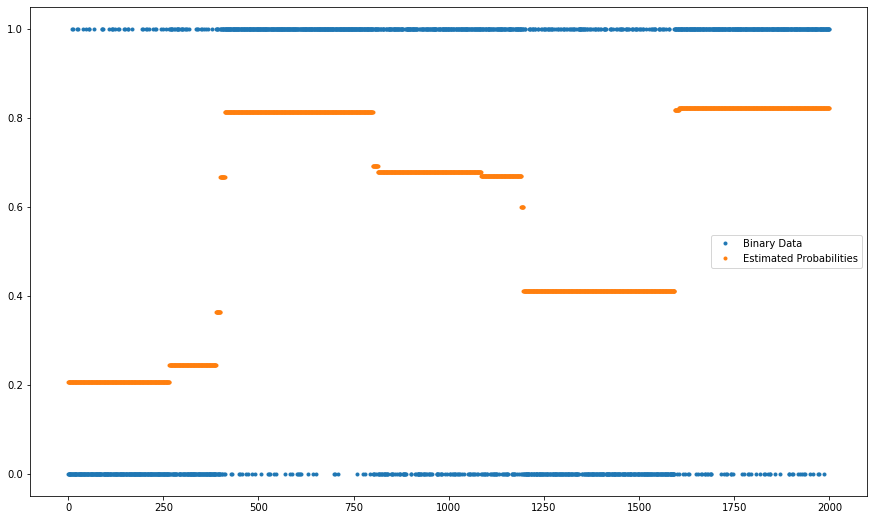

Total iterations: 64


In [235]:

#theta = np.random.randn(*binseq.shape)
theta = np.zeros_like(binseq)
y = binseq.copy()

bta = 0.8
epi = 1e-6
lam = 20
n = binseq.shape[0]
cot = 0

obj_0 = obj(y,theta,lam)
theta_0 = theta.copy()

while(True):
    t = 1
    G = Gt(theta,t,y,lam)
    while (g(theta-t*G,y) > g(theta,y)-t*np.dot(gGrad(theta,y),G)+0.5*t*(np.linalg.norm(G)**2)):
        t = bta*t
        cot = cot+1
        G = Gt(theta,t,y,lam)
    cot = cot+1
    prox_dp(n=n, y=theta-t*gGrad(theta,y), lam=lam*t, theta=theta)
    obj_1 = obj(y,theta,lam)
    
    if (obj_0 - obj_1) < epi:
         break
    
    obj_0 = obj_1


plt.figure(figsize=(15,9))
plt.plot(binseq,'.',label='Binary Data')
plt.plot((np.exp(theta)/(1+np.exp(theta))),'.',label='Estimated Probabilities')
plt.legend()
plt.show()
print('Total iterations:',cot)
# print(theta)
# print(obj_1)



In [236]:

z = 2*y-1

#Form in 5
print('Loss in (5):',g(theta,y))
print('Penalty in (5):',h(theta,lam))

#Form in 3

Dx = -np.eye(z.shape[0]-1)
Dx = np.insert(Dx, 0, 0, axis=1)
Dx = np.insert(Dx, z.shape[0]-1, 0, axis=0)

D = np.eye(z.shape[0])+Dx
D = np.delete(D,z.shape[0]-1,axis=0)
print('D is :\n',D)

print('Loss in (3):',gd(theta,z))
print('Penalty in (3):',hd(D,theta,lam))

Loss in (5): 983.4964472302881
Penalty in (5): 130.84182101236965
D is :
 [[ 1. -1.  0. ...  0.  0.  0.]
 [ 0.  1. -1. ...  0.  0.  0.]
 [ 0.  0.  1. ...  0.  0.  0.]
 ...
 [ 0.  0.  0. ... -1.  0.  0.]
 [ 0.  0.  0. ...  1. -1.  0.]
 [ 0.  0.  0. ...  0.  1. -1.]]
Loss in (3): 983.4964472302881
Penalty in (3): 130.84182101236965


In [237]:

from cvxopt import matrix, solvers

lam = 20
delta = 0.01

n = z.shape[0]
m = D.shape[0]
A = (z*D).T
A = np.concatenate((A,-A,np.eye(m),-np.eye(m)))
b1 = (1-delta)*np.ones(n)
b2 = -delta*np.ones(n)
b3 = (lam-delta)*np.ones(m)
b = np.concatenate((b1,b2,b3,b3))
c = np.random.rand(m)

A = matrix(A)
b = matrix(b)
c = matrix(c)

sol=solvers.lp(c,A,b)
u0 = np.array(sol['x'])
u0 = u0.squeeze()

     pcost       dcost       gap    pres   dres   k/t
 0: -3.0981e+00 -1.1752e+05  1e+05  7e-02  5e-16  1e+00
 1: -5.8645e+03 -3.3793e+04  3e+04  2e-02  6e-15  4e-01
 2: -1.1087e+04 -3.0498e+04  2e+04  1e-02  1e-14  6e-01
 3: -1.5443e+04 -2.6206e+04  1e+04  7e-03  2e-14  5e-01
 4: -1.7257e+04 -2.4013e+04  7e+03  4e-03  2e-14  4e-01
 5: -1.8619e+04 -2.1958e+04  3e+03  2e-03  1e-14  2e-01
 6: -1.9436e+04 -2.0729e+04  1e+03  8e-04  1e-14  1e-01
 7: -1.9647e+04 -2.0348e+04  7e+02  4e-04  9e-15  7e-02
 8: -1.9780e+04 -2.0113e+04  3e+02  2e-04  6e-15  4e-02
 9: -1.9844e+04 -1.9981e+04  1e+02  8e-05  6e-14  2e-02
10: -1.9878e+04 -1.9906e+04  3e+01  2e-05  1e-13  4e-03
11: -1.9882e+04 -1.9890e+04  8e+00  5e-06  4e-13  1e-03
12: -1.9883e+04 -1.9885e+04  2e+00  1e-06  6e-13  2e-04
13: -1.9884e+04 -1.9884e+04  5e-01  3e-07  5e-13  6e-05
14: -1.9884e+04 -1.9884e+04  6e-02  4e-08  6e-13  8e-06
15: -1.9884e+04 -1.9884e+04  9e-04  5e-10  7e-13  1e-07
Optimal solution found.


In [238]:
def g1(X):
    return np.sum(X*np.log(X)+(1-X)*np.log(1-X))

def h1(X,u,lam,tau):
    return -tau*(np.sum(np.log(X)+np.log(1-X))+np.sum(np.log(lam-u)+np.log(u+lam)))

def obj1(ta,Dt,u,y,lam,tau):
    X = y*Dt.dot(u)
    return ta*g1(X)+h1(X,u,lam,tau)
    #return h1(Dt,u,y,lam,tau)

def g1Grad(X,D,y):
    G = np.log(X/(1-X))
    return np.asarray(np.sum((D.multiply(G*y)),axis=1)).T.squeeze()
   
def h1Grad(X,D,u,y,lam,tau):
    H1 = np.asarray(np.sum((D.multiply((1/X)*y)-D.multiply((1/(1-X))*y)),axis=1)).T.squeeze()
    H2 = -2*u*(1/(lam-u))*(1/(lam+u))
    return -tau*(H1+H2)

def obj1Grad(ta,Dt,D,u,y,lam,tau):
    X = y*Dt.dot(u)
    return ta*g1Grad(X,D,y)+h1Grad(X,D,u,y,lam,tau)
    
    
def opr(x):
    return np.diag(x[:-1]) + np.diag(x[1:]) + np.diag(-x[1:-1],k=1) + np.diag(-x[1:-1],k=-1)
    
def g2Grad(Dt,y,u):
    return opr((1 / ((y*Dt.dot(u))*(1-y*Dt.dot(u)))))

def h2Grad(Dt,u,y,lam,tau):
    return tau*(2*np.diag((lam**2+u**2) / ((lam**2-u**2)**2)) + opr((1/(Dt.dot(u)))**2 + (1/(1-y*Dt.dot(u)))**2))

def obj2Grad(ta,Dt,u,y,lam,tau):
    return ta*g2Grad(Dt,y,u)+h2Grad(Dt,u,y,lam,tau)
    
    
    

In [239]:
# 4.(a)

from scipy.sparse import dia_matrix
Ds = dia_matrix(D)
Dts = dia_matrix(D.T)

lam = 20
tau = 1
ta = 5
mu = 10
bta = 0.8
kMax = 50000
epi_out = 1e-8
epi_in = 1e-6
alpha = 0.5
u = u0
m = 7998
cot = 0
for j in range(kMax):
    obj_0 = obj1(ta,Dts,u,z,lam,tau)
    print('Outer Iteration',j,':')
    print(obj_0)
    for k in range(kMax):
        t = 1
        grad1 = obj1Grad(ta,Dts,Ds,u,z,lam,tau)
        v = np.dot(-np.linalg.inv(obj2Grad(ta,Dts,u,z,lam,tau)),grad1)
        c1 = obj1(ta,Dts,u+t*v,z,lam,tau)
        while(np.isnan(c1)):
            t = bta*t
            c1 = obj1(ta,Dts,u+t*v,z,lam,tau)
        c2 = obj1(ta,Dts,u,z,lam,tau)
        c3 = np.dot(grad1,v)
        while(c1>c2+alpha*t*c3):
            t = bta*t
            c1 = obj1(ta,Dts,u+t*v,z,lam,tau)

        u = u+t*v
        obj_1 = c1
        cot = cot+1
        if(obj_0-obj_1 < epi_in):
            break
        obj_0 = obj_1

    if(m/ta < epi_out):
        break
    ta = mu*ta
print(cot)

Outer Iteration 0 :
7052.310040830246
Outer Iteration 1 :
-61937.69835370894
Outer Iteration 2 :
-562320.9327658572
Outer Iteration 3 :
-5577845.737824931
Outer Iteration 4 :
-55723630.6264162
Outer Iteration 5 :
-557175887.687705
Outer Iteration 6 :
-5571698075.090639
Outer Iteration 7 :
-55716920120.23973
Outer Iteration 8 :
-557169140803.0332
Outer Iteration 9 :
-5571691347868.523
Outer Iteration 10 :
-55716913418761.82
Outer Iteration 11 :
-557169134127931.25
Outer Iteration 12 :
-5571691341219865.0
112


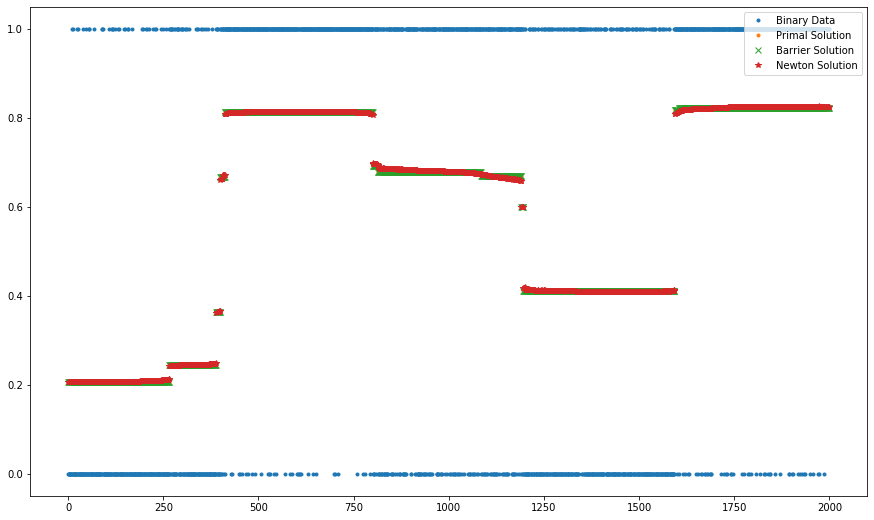

In [240]:
# 4.(d)
X = Dts.dot(u)
beta = -z*np.log(X/(z-X))
plt.figure(figsize=(15,9))
plt.plot(binseq,'.',label='Binary Data')
plt.plot((np.exp(theta)/(1+np.exp(theta))),'.',label='Primal Solution')
plt.plot((np.exp(beta)/(1+np.exp(beta))),'x',label='Barrier Solution')
un = np.load("u_newton.npy")
X = Dts.dot(un)
beta = -z*np.log(X/(z-X))
plt.plot((np.exp(beta)/(1+np.exp(beta))),'*',label='Newton Solution')
plt.legend(loc='upper right')
plt.show()
# print('Estimated probabilites are closed to those in part(b). ')
# print('Primal Value:',np.sum(np.log(1+np.exp(-z*beta)))+lam*np.linalg.norm(Ds.dot(beta),1))
# print('Primal Value in (b):',gd(theta,z)+hd(D,theta,lam))
# print('Primal Value in (b) is lower.')

In [241]:
# 4.(b) (cold)
y = binseq.copy()

bta = 0.8
epi = 1e-6
lamb = np.flipud(np.logspace(-3.0, np.log10(200),80))
n = binseq.shape[0]
cot = 0
kMax = 1000
obj_0 = obj(y,theta,lam)
iter_num_cp = []
opt_value_cp = []
#theta_0 = theta.copy()
for lam in lamb:
    cot = 0
    theta = np.zeros_like(binseq)
    obj_0 = obj(y,theta,lam)
    for k in range(kMax):
        t = 1
        G = Gt(theta,t,y,lam)
        while (g(theta-t*G,y) > g(theta,y)-t*np.dot(gGrad(theta,y),G)+0.5*t*(np.linalg.norm(G)**2)):
            t = bta*t
            cot = cot+1
            G = Gt(theta,t,y,lam)
        cot = cot+1
        prox_dp(n=n, y=theta-t*gGrad(theta,y), lam=lam*t, theta=theta)
        obj_1 = obj(y,theta,lam)

        if (obj_0 - obj_1) < epi:
             break

        obj_0 = obj_1
#         if (cot>=1000):
#             break
        
    iter_num_cp.append(cot)
    opt_value_cp.append(obj_0)


In [242]:
# 4.(b) (warm)
y = binseq.copy()

bta = 0.8
epi = 1e-6
lamb = np.flipud(np.logspace(-3.0, np.log10(200),80))
n = binseq.shape[0]
cot = 0
kMax = 1000
obj_0 = obj(y,theta,lam)
iter_num_wp = []
opt_value_wp = []
#theta_0 = theta.copy()
theta = np.zeros_like(binseq)
for lam in lamb:
    cot = 0
    #theta = np.load('theta.npy')
    obj_0 = obj(y,theta,lam)
    for k in range(kMax):
        t = 1
        G = Gt(theta,t,y,lam)
        while (g(theta-t*G,y) > g(theta,y)-t*np.dot(gGrad(theta,y),G)+0.5*t*(np.linalg.norm(G)**2)):
            t = bta*t
            cot = cot+1
            G = Gt(theta,t,y,lam)
        cot = cot+1
        prox_dp(n=n, y=theta-t*gGrad(theta,y), lam=lam*t, theta=theta)
        obj_1 = obj(y,theta,lam)

        if (obj_0 - obj_1) < epi:
             break
        obj_0 = obj_1
#         if (cot>=1000):
#             break
    iter_num_wp.append(cot)
    opt_value_wp.append(obj_0)

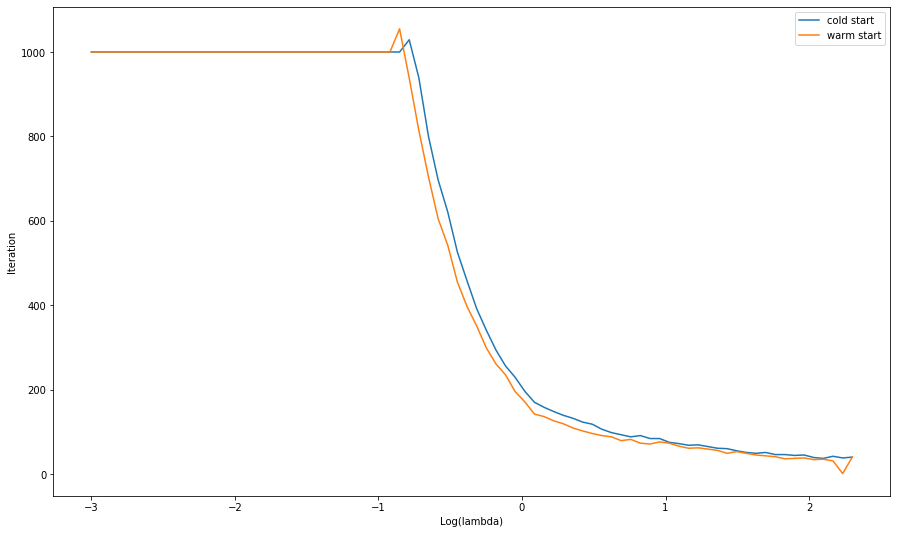

In [243]:
plt.figure(figsize=(15,9))
plt.plot(np.log10(lamb),iter_num_cp,label='cold start')
plt.plot(np.log10(lamb),iter_num_wp,label='warm start')
plt.xlabel('Log(lambda)')
plt.ylabel('Iteration')
plt.legend(loc='upper right')
plt.show()

In [ ]:
# 4.(c) (cold)


from cvxopt import matrix, solvers
from scipy.sparse import dia_matrix



# lam = 1e-3
# delta = 1e-6

# n = z.shape[0]
# m = D.shape[0]
# A = (z*D).T
# A = np.concatenate((A,-A,np.eye(m),-np.eye(m)))
# b1 = (1-delta)*np.ones(n)
# b2 = -delta*np.ones(n)
# b3 = (lam-delta)*np.ones(m)
# b = np.concatenate((b1,b2,b3,b3))
# c = np.random.rand(m)

# A = matrix(A)
# b = matrix(b)
# c = matrix(c)

# sol=solvers.lp(c,A,b)
# u0 = np.array(sol['x'])
# u0 = u0.squeeze()

from scipy.sparse import dia_matrix
Ds = dia_matrix(D)
Dts = dia_matrix(D.T)

lamb = np.logspace(-3.0, np.log10(200),80)
tau = 1
ta = 5
mu = 10
bta = 0.8
kMax = 50000
epi_out = 1e-8
epi_in = 1e-6
alpha = 0.5
u = u0
m = 7998

iter_num_cb = []
opt_value_cb = []

for lam in lamb:
    u = u0.copy()
    cot = 0
    obj_0 = obj1(ta,Dts,u,z,lam,tau)
    for j in range(kMax):
        obj_0 = obj1(ta,Dts,u,z,lam,tau)
        
        for k in range(kMax):
            t = 1
            grad1 = obj1Grad(ta,Dts,Ds,u,z,lam,tau)
            grad2 = dia_matrix(obj2Grad(ta,Dts,u,z,lam,tau))
            v = -inv(grad2).dot(grad1)
            c1 = obj1(ta,Dts,u+t*v,z,lam,tau)
            while(np.isnan(c1)):
                t = bta*t
                c1 = obj1(ta,Dts,u+t*v,z,lam,tau)
            c2 = obj1(ta,Dts,u,z,lam,tau)
            c3 = np.dot(grad1,v)
            while(c1>c2+alpha*t*c3):
                t = bta*t
                c1 = obj1(ta,Dts,u+t*v,z,lam,tau)
#             print(t)
#             print(cot)
#             print(ta)
#             print(g1(z*Dts.dot(u)))
            u = u+t*v
            obj_1 = c1
            cot = cot+1
            if((obj_0-obj_1)/ta < epi_in):
                break
            obj_0 = obj_1
            if (cot>=100):
                break
            
        if(m/ta < epi_out):
            break
        ta = mu*ta
        if (cot>=100):
            break
        
    iter_num_cb.append(cot)
    opt_value_cb.append(obj_0)



In [ ]:
# 4.(c) (warm)

from scipy.sparse import dia_matrix
Ds = dia_matrix(D)
Dts = dia_matrix(D.T)

lamb = np.logspace(-3.0, np.log10(200),80)
#lamb = np.flipud(np.logspace(-3.0, np.log10(200),100))
tau = 1
ta = 5
mu = 10
bta = 0.8
kMax = 5000
epi_out = 1e-8
epi_in = 1e-6
alpha = 0.5
m = 7998
u = np.load('u0.npy')

iter_num_wb = []
opt_value_wb = []

for lam in lamb:
    #u = np.load("u_barrier.npy")
    cot = 0
    ta = 5
    obj_0 = obj1(ta,Dts,u,z,lam,tau)
    for j in range(kMax):
        obj_0 = obj1(ta,Dts,u,z,lam,tau)
        
        for k in range(kMax):
            t = 1
            grad1 = obj1Grad(ta,Dts,Ds,u,z,lam,tau)
            grad2 = dia_matrix(obj2Grad(ta,Dts,u,z,lam,tau))
            v = -inv(grad2).dot(grad1)
            c1 = obj1(ta,Dts,u+t*v,z,lam,tau)
            while(np.isnan(c1)):
                t = bta*t
                c1 = obj1(ta,Dts,u+t*v,z,lam,tau)
            c2 = obj1(ta,Dts,u,z,lam,tau)
            c3 = np.dot(grad1,v)
            while(c1>c2+alpha*t*c3):
                t = bta*t
                c1 = obj1(ta,Dts,u+t*v,z,lam,tau)
            u = u+t*v
            obj_1 = c1
            cot = cot+1
            if((obj_0-obj_1)/ta < epi_in):
                break
            obj_0 = obj_1
            if (cot>=100):
                break
        if(m/ta < epi_out):
            break
        ta = mu*ta
        if (cot>=100):
            break
    iter_num_wb.append(cot)
    print(cot)
    X = Dts.dot(u)
    beta = -z*np.log(X/(z-X))
    opt_value_wb.append(obj(y,beta,lam))


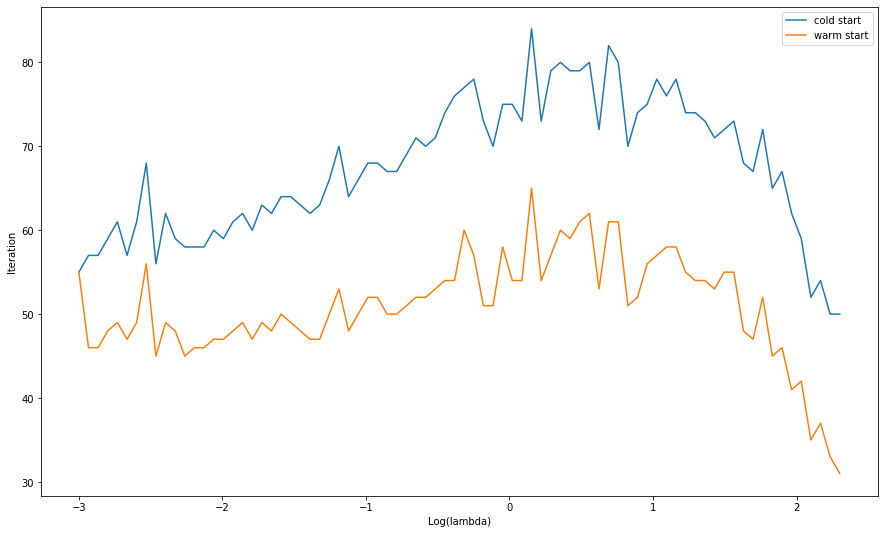

In [246]:
lamb = np.logspace(-3.0, np.log10(200),80)
plt.figure(figsize=(15,9))
iter_num_cb = np.load('cb_iter.npy')
iter_num_wb = np.load('wb_iter.npy')
plt.plot(np.log10(lamb),iter_num_cb,label='cold start')
plt.plot(np.log10(lamb),iter_num_wb,label='warm start')
plt.xlabel('Log(lambda)')
plt.ylabel('Iteration')
plt.legend(loc='upper right')
plt.show()

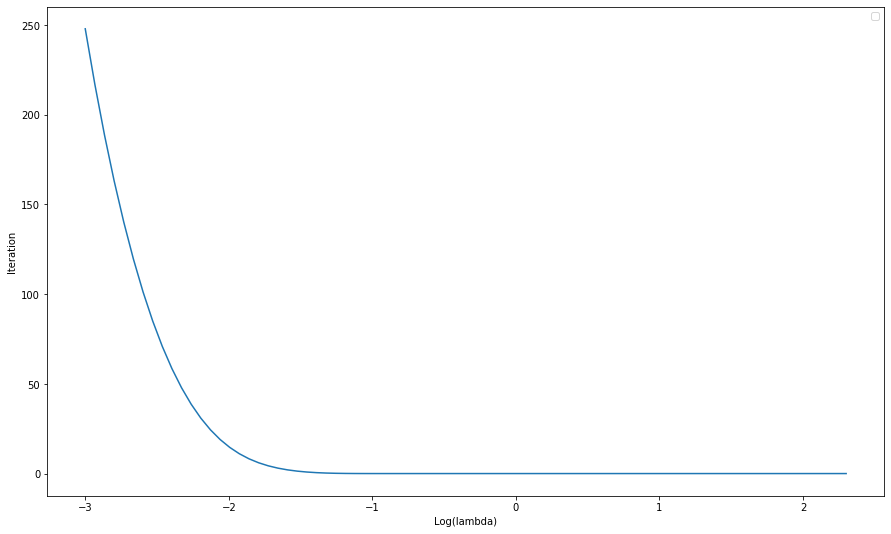

In [245]:
# 4.(d)
lamb = np.logspace(-3.0, np.log10(200),80)
plt.figure(figsize=(15,9))
opt_value_wb = np.load('wb_opt.npy')
plt.plot(np.log10(lamb),np.flipud(np.array(opt_value_wp))-np.array(opt_value_wb))
plt.xlabel('Log(lambda)')
plt.ylabel('Iteration')
plt.legend(loc='upper right')
plt.show()